#### This notebook compares the CESM 0.1º and 1º O$_2$ distributions and zonal velcoity fields to observations

---
### Import packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings

import xarray as xr
import numpy as np

from tqdm import tqdm
import bokeh

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
from cartopy import util
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmocean
import pop_tools 

from pop_tools import get_grid
import proplot
from utils import *


---
## Spin up Dask Cluster/Client

In [57]:
C=CLSTR(1,25,109,10)

In [18]:
C

<Client: 'tcp://10.12.206.46:41019' processes=0 threads=0, memory=0 B>

## Read 0.1º CESM Outputs

In [ ]:
path = f'/glade/scratch/yeddebba/Mesoscale/HR/TPAC'
file = f'{path}/*_CLM.nc'
dsu = xr.open_mfdataset(file, decode_times=False, decode_coords=False, data_vars=['UVEL','VVEL','O2','ULAT','ULONG','TLAT','TLONG','z_t'])
dsu

path = f'/glade/scratch/yeddebba/Mesoscale/LR/CLM/'
file = f'{path}/*.CLM.nc'
dsl = xr.open_mfdataset(file, decode_times=False, decode_coords=False, data_vars=['UVEL','VVEL','O2','ULAT','ULONG','TLAT','TLONG','z_t'])
dsl

# path = f'/glade/scratch/yeddebba/TPOSE/'
# file = f'{path}/tpose_[UV]VEL_monthly_2010to2017.nc'
# dst = xr.open_mfdataset(file, decode_times=False, decode_coords=False)
# dst

path = f'/glade/work/yeddebba/BTPOSE/www.ecco.ucsd.edu/DATA/TROPAC/bgc'
file = f'{path}/tpose_201[01234567]_[UV]VEL.nc'
dst = xr.open_mfdataset(file, decode_times=False, decode_coords=False)
dst

path = f'/glade/work/yeddebba/BTPOSE/www.ecco.ucsd.edu/DATA/TROPAC/bgc'
file = f'{path}/tpose_201[01234567]_O2.nc'
dsto = xr.open_mfdataset(file, decode_times=False, decode_coords=False)
dsto

path = f'/glade/work/yeddebba/drifter/drifter_annualmeans.nc'
dd = xr.open_mfdataset({path})
dd

path='/glade/scratch/yeddebba/Mesoscale/OBS/johnson_velocities.cdf'
dj = xr.open_dataset(path, decode_times=False, decode_coords=False)
dj

# Unit Conversion
umol_kg_mmol_m3=1*1.027
ml_l_mmol_m3=44.4

# WOA O2 data from https://www.nodc.noaa.gov/OC5/indprod.html: 
path='/glade/scratch/yeddebba/Mesoscale/OBS'
file = f'{path}/WOA2018_O2_clm.nc'
dsw = xr.open_dataset(file, decode_times=False, decode_coords=False)
varname=['o_an','lat','lon','depth'] 
dsw=dsw.drop([v for v in dsw.variables if v not in varname])
dsw=dsw*umol_kg_mmol_m3
dsw

# Using CARS CSIRO Atlas from: http://www.marine.csiro.au/~dunn/cars2009/ 
path='/glade/scratch/yeddebba/Mesoscale/OBS'  
file = f'{path}/oxygen_cars2009.nc'
dsc = xr.open_dataset(file, decode_times=False, decode_coords=False)
varname=['o2','lat','lon','depth'] 
dsc=dsc.drop([v for v in dsc.variables if v not in varname])  
dsc=dsc*ml_l_mmol_m3
dsc

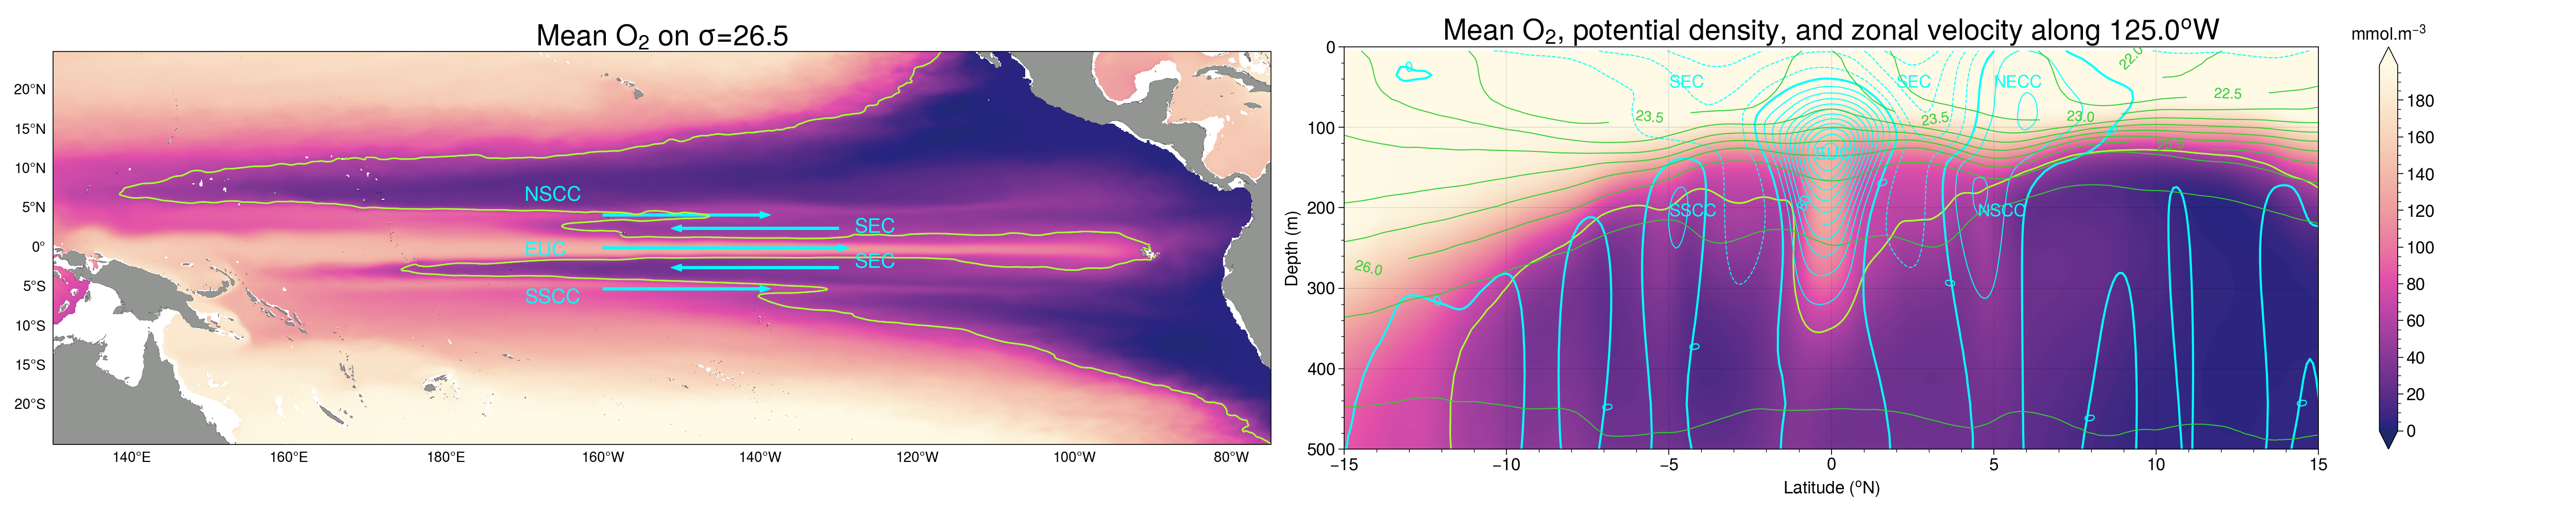

In [54]:
fig=plt.figure(figsize=(25,5),facecolor='white')
fst=14; fs=12; fsx=10
o2_clr='sunset_r'
omz_clr='lime'
u_clr='cyan'
pd_clr='limegreen'
k=2
rho=1.0265
E=-180-50; W=-75; S=-25; N=25
coor=[E,W,S,N]; D=1; CL=215.0
lon_lab=[120,140,160,180,-160,-140,-120,-100,-80]
lat_lab=np.arange(S,N,10)
lmax=200
lo = 60.; hi = lo ; dc = 0.1; cnlevels = np.arange(lo, hi+dc, dc)
lo = 5.; hi = lo ; dc = 0.1; cnlevels2 = np.arange(lo, hi+dc, dc)
varq=[ds.O2.isel(z_t=15),]
long=[ds.TLONG]
lat=[ds.TLAT]
units='mmol.m$^{-3}$'

ax = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180.0))
ax.set_extent([E,W,S,N],crs=cartopy.crs.PlateCarree())
pc= ax.pcolormesh(long[0], lat[0], varq[0],vmin=lmax*0, vmax=lmax, cmap=o2_clr,transform=ccrs.PlateCarree()) #, 
pch= ax.contour(long[0], lat[0],varq[0], colors=omz_clr, linewidths=1.0, levels=cnlevels,transform=ccrs.PlateCarree())
ax.set_title(r'Mean O$_2$ on $\sigma$='+str(round((rho-1)*1e3,1)),pad=0.01,fontsize=fst+6,loc='center')
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.1, edgecolor='black', facecolor='grey'))
ax.tick_params(axis='both', labelsize=fst)
gl=ax.gridlines(draw_labels=True)
gl.xlabel_style = {'size': fsx, 'color': 'black'}; gl.ylabel_style = {'size': fsx, 'color': 'black'}; 
gl.xlabels_top = False; gl.ylabels_right= False; gl.xlines = False; gl.ylines = False
gl.xlocator = mticker.FixedLocator([140,160,180,-160,-140,-120,-100,-80]); gl.ylocator = mticker.FixedLocator(np.arange(S,N,5))
gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER

plt.text(10, 6, 'NSCC', {'color': u_clr, 'fontsize': fst})
plt.arrow(20, 4.2, 20, 0, width=0.3, color=u_clr)
plt.text(10, -7, 'SSCC', {'color': u_clr, 'fontsize': fst})
plt.arrow(20, -5.2, 20, 0, width=0.3, color=u_clr)
plt.text(10, -1, 'EUC', {'color': u_clr, 'fontsize': fst})
plt.arrow(20, 0, 30, 0, width=0.3, color=u_clr)
plt.text(52, 2, 'SEC', {'color': u_clr, 'fontsize': fst})
plt.arrow(50, 2.5, -20, 0, width=0.3, color=u_clr)
plt.text(52, -2.5, 'SEC', {'color': u_clr, 'fontsize': fst})
plt.arrow(50, -2.5, -20, 0, width=0.3, color=u_clr)



In [30]:
savefig(fig,'figure_1')